# CasADi's Opti Tool

In [1]:
import os
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
import matplotlib.pyplot as plt
from casadi import (
    Opti,
    diff, sum1, sum2,
    jacobian, hessian
)

## 1. Regular Springs

### 1.1. Find the equilibrium position of the hanging chain

In [2]:
N = 25  # number of point masses

In [3]:
# Constants
m = 40 / N # mass [kg]
D = 70 * N # spring constant [J/m^2]
g = 9.81 # gravitational constant [m/s^2]
L = 5 / N  # reference length [m]

In [4]:
opti = Opti()

x = opti.variable(N)
y = opti.variable(N)

x.shape, y.shape

((25, 1), (25, 1))

In [5]:
spring_potential = D * sum1(diff(x) ** 2 + diff(y) ** 2) / 2.
gravitional_potential = m * g * sum1(y)
V = spring_potential + gravitional_potential
assert V.shape == (1, 1)
opti.f.shape

(1, 1)

In [6]:
opti.minimize(V)
opti.x.shape

(50, 1)

In [7]:
# Add constraints
opti.subject_to(x[0] == -2)
opti.subject_to(y[0] == 0)
opti.subject_to(x[-1] == 2)
opti.subject_to(y[-1] == 0)
opti.g.shape

(4, 1)

In [8]:
opti.solver('ipopt')
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       98

Total number of variables............................:       50
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality c

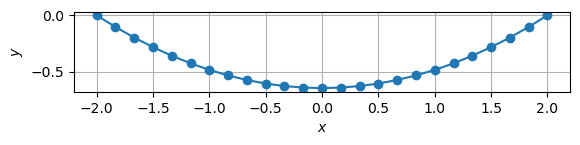

In [9]:
fig, ax = plt.subplots()
ax.plot(sol.value(x), sol.value(y), '-o')
ax.set_aspect('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.grid()
plt.show()

In [10]:
# Alternative without constrainst
opti2 = Opti()

x2 = opti2.variable(N - 2)
y2 = opti2.variable(N - 2)

x2.shape, y2.shape

((23, 1), (23, 1))

In [11]:
spring_potential = D * (
    (x2[0] - -2.) ** 2
    + y2[0] ** 2
    + (x2[-1] - 2.) ** 2
    + y2[-1] ** 2 
    + sum1((x2[1:] - x2[:-1]) ** 2 + (y2[1:] - y2[:-1]) ** 2)
) / 2.
gravitional_potential = m * g * sum1(y2)
V2 = spring_potential + gravitional_potential
assert V2.shape == (1, 1)

In [12]:
opti2.minimize(V2)
opti2.solver('ipopt')
sol2 = opti2.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       90

Total number of variables............................:       46
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.0000000e+03 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

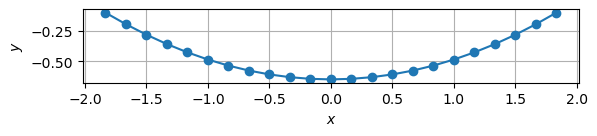

In [13]:
fig, ax = plt.subplots()
ax.plot(sol2.value(x2), sol2.value(y2), '-o')
ax.set_aspect('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.grid()
plt.show()

In [14]:
assert max(np.abs(np.array(sol.value(x[1:-1])) - np.array(sol2.value(x2)))) < 1e-9
assert max(np.abs(np.array(sol.value(y[1:-1])) - np.array(sol2.value(y2)))) < 1e-8

### 1.2. Inspect the structure of the Hessian

In [15]:
opti.x

MX(vertcat(opti0_x_1, opti0_x_2))

In [16]:
hessian(opti.f, opti.x)[0].sparsity().spy()

**................................................
***...............................................
.***..............................................
..***.............................................
...***............................................
....***...........................................
.....***..........................................
......***.........................................
.......***........................................
........***.......................................
.........***......................................
..........***.....................................
...........***....................................
............***...................................
.............***..................................
..............***.................................
...............***................................
................***...............................
.................***..............................
..................***..........

### 1.3. Inspect the value of the Lagrange gradient at the solution

In [17]:
opti.lam_g.shape

(4, 1)

In [18]:
lag = opti.f + opti.lam_g.T @ opti.g
lag.shape

(1, 1)

In [19]:
grad_lag = sol.value(jacobian(lag, opti.x))
grad_lag

array([ 2.27373675e-13, -3.97903932e-13,  0.00000000e+00,  0.00000000e+00,
        3.97903932e-13,  0.00000000e+00, -3.97903932e-13,  3.97903932e-13,
       -3.97903932e-13,  1.70530257e-13,  5.68434189e-14, -5.68434189e-14,
        5.68434189e-14, -1.70530257e-13,  2.27373675e-13, -2.84217094e-13,
        1.70530257e-13, -3.41060513e-13,  5.68434189e-13, -3.97903932e-13,
       -3.97903932e-13,  7.95807864e-13, -3.97903932e-13,  0.00000000e+00,
        5.68434189e-14,  0.00000000e+00,  2.84217094e-14, -2.84217094e-14,
        2.84217094e-14, -5.68434189e-14, -8.52651283e-14, -7.10542736e-14,
        2.27373675e-13, -7.10542736e-14,  1.20792265e-13, -7.10542736e-14,
       -7.10542736e-14,  1.24344979e-13, -7.10542736e-14,  1.24344979e-13,
       -6.39488462e-14, -7.81597009e-14,  2.84217094e-14,  2.84217094e-14,
        1.42108547e-14,  4.26325641e-14, -1.42108547e-13,  5.68434189e-14,
        2.84217094e-14, -2.84217094e-14])

In [20]:
np.linalg.norm(grad_lag)

1.6727132820544395e-12